# Neural Style Transformer

In [ ]:
!pip3 uninstall torch torchvision
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [1]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
class FileManager():

  def __init__(self):
    pass
  
  def get_path(self):
    pass
  
  def download_file(self):
    pass

In [4]:
class ImageProcessing():

  def __init__(self, content_image_name, style_image_name):
    
    self.content_image_name = content_image_name
    self.style_image_name = style_image_name

    self.imsize = min(min(self.get_imsize(self.content_image_name)), 
                      min(self.get_imsize(self.style_image_name)))
    
    self.loader = transforms.Compose([
    transforms.Resize(self.imsize),
    transforms.CenterCrop(self.imsize),
    transforms.ToTensor()])

    self.device = DEVICE
    self.unloader = transforms.ToPILImage() 

 
  def get_imsize(self, image_name):
    image = Image.open(image_name)
    return image.size


  def image_loader(self, image_name):
    image = Image.open(image_name)
    image = self.loader(image).unsqueeze(0)
    return image.to(self.device, torch.float)
  

  def imshow(self, tensor, title=None):
    plt.ion()
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = self.unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
  

  def show_images(self):
    style_img = self.image_loader(self.style_image_name)
    content_img = self.image_loader(self.content_image_name)
    self.imshow(style_img, title='Style Image')
    self.imshow(content_img, title='Content Image')


In [5]:
!ls /content/drive/MyDrive/NST_proj/images

city-day.jpg  city-night.jpg  city-sunset.jpg


In [6]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach() 
            self.loss = F.mse_loss(self.target, self.target )         # to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [7]:
class StyleLoss(nn.Module):
        
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = self.get_gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)        # to initialize with something


        def forward(self, input):
            G = self.get_gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input
        

        def get_gram_matrix(self, input):
            batch_size, f_map_num, h, w = input.size()            # batch size(=1)
            # f_map_num=number of feature maps
            # (h,w)=dimensions of a feature map (N=h*w)

            features = input.view(batch_size * f_map_num, h * w)  # resise F_XL into \hat F_XL

            G = torch.mm(features, features.t())                  # compute the gram product

            # we 'normalize' the values of the gram matrix
            # by dividing by the number of element in each feature maps.
            return G.div(batch_size * h * w * f_map_num)

In [8]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [28]:
class NST():

      def __init__(self, normalization_mean=None, normalization_std=None, 
                   content_layers=None, style_layers=None, cnn=None):
        
          self.normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE) \
            if normalization_mean == None else normalization_mean

          self.normalization_std  = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE) \
            if normalization_std  == None else normalization_std
          
          self.content_layers = ['conv_4'] \
            if content_layers == None else content_layers

          self.style_layers   = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] \
            if style_layers   == None else style_layers
          
          # we use pretrained model to extract features
          self.cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval() \
            if cnn == None else cnn
          
          self.output = None
      

      def get_style_model_and_losses(self, style_img_tensor, content_img_tensor):
          cnn = copy.deepcopy(self.cnn)

          # normalization module
          normalization = Normalization(self.normalization_mean, self.normalization_std).to(DEVICE)

          # just in order to have an iterable access to or list of content/syle
          # losses
          content_losses = []
          style_losses = []

          # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
          # to put in modules that are supposed to be activated sequentially
          model = nn.Sequential(normalization)

          i = 0  # increment every time we see a conv
          for layer in cnn.children():
              if isinstance(layer, nn.Conv2d):
                  i += 1
                  name = 'conv_{}'.format(i)
              elif isinstance(layer, nn.ReLU):
                  name = 'relu_{}'.format(i)
                  # The in-place version doesn't play very nicely with the ContentLoss
                  # and StyleLoss we insert below. So we replace with out-of-place
                  # ones here.
                  layer = nn.ReLU(inplace=False)
              elif isinstance(layer, nn.MaxPool2d):
                  name = 'pool_{}'.format(i)
              elif isinstance(layer, nn.BatchNorm2d):
                  name = 'bn_{}'.format(i)
              else:
                  raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

              model.add_module(name, layer)

              if name in self.content_layers:
                  # add content loss:
                  target = model(content_img_tensor).detach()
                  content_loss = ContentLoss(target)
                  model.add_module("content_loss_{}".format(i), content_loss)
                  content_losses.append(content_loss)

              if name in self.style_layers:
                  # add style loss:
                  target_feature = model(style_img_tensor).detach()
                  style_loss = StyleLoss(target_feature)
                  model.add_module("style_loss_{}".format(i), style_loss)
                  style_losses.append(style_loss)

          # now we trim off the layers after the last content and style losses
          for i in range(len(model) - 1, -1, -1):
              if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                  break

          model = model[:(i + 1)]

          return model, style_losses, content_losses
      

      def get_input_optimizer(self, input_img_tensor):
          # this line to show that input is a parameter that requires a gradient
          optimizer = optim.LBFGS([input_img_tensor.requires_grad_()]) 
          return optimizer
      

      def run_style_transfer(self, content_img_tensor, style_img_tensor, input_img_tensor, 
                             num_steps=1000, style_weight=10000000, content_weight=1):
         
          """Run the style transfer."""
          import time
          start_time = time.time()
          print('Start training...')

          print('Building the style transfer model..')
          model, style_losses, content_losses = \
              self.get_style_model_and_losses(style_img_tensor, content_img_tensor)
          print('Execution time: %s seconds' % (time.time() - start_time))

          optimizer = self.get_input_optimizer(input_img_tensor)

          print('Optimizing..')
          run = [0]
          while run[0] <= num_steps:

              def closure():
                  # correct the values 
                  input_img_tensor.data.clamp_(0, 1)

                  optimizer.zero_grad()

                  model(input_img_tensor)

                  style_score = 0
                  content_score = 0

                  for sl in style_losses:
                      style_score += sl.loss
                  for cl in content_losses:
                      content_score += cl.loss
                  
                  # considering weights
                  style_score *= style_weight
                  content_score *= content_weight

                  loss = style_score + content_score
                  loss.backward()

                  run[0] += 1
                  if run[0] % 50 == 0:
                      print("run {}:".format(run))
                      print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                          style_score.item(), content_score.item()))
                      print("Execution time: %s seconds" % (time.time() - start_time))
                      print()

                  return style_score + content_score

              optimizer.step(closure)

          # a last correction...
          input_img_tensor.data.clamp_(0, 1)

          return input_img_tensor
      
      def run_NST(self, style_image_name, content_image_name):
          import time
          start_time = time.time()

          print('Getting pictures...')
          image_proc = ImageProcessing(content_image_name, style_image_name)
          print('Execution time: %s seconds' % (time.time() - start_time))

          print('Showing pictures')
          image_proc.show_images()
          print('Execution time: %s seconds' % (time.time() - start_time))

          # running
          print('Loading content image...')
          content_img = image_proc.image_loader(content_image_name)
          print('Execution time: %s seconds' % (time.time() - start_time))

          input_img   = content_img.clone()
          # if you want to use white noise instead uncomment the below line:
          # input_img = torch.randn(content_img.data.size(), device=device)
          print('Loading style image...')
          style_img   = image_proc.image_loader(style_image_name)
          print('Execution time: %s seconds' % (time.time() - start_time))

          output = self.run_style_transfer(content_img, style_img, input_img)
          print('Saving the result...')
          self.output = output
          print('Execution time: %s seconds' % (time.time() - start_time))
          # result
          #if not output:
          #    raise TypeError('Nothing to show')
          #else:
          plt.figure()
          image_proc.imshow(output, title='Output Image')
          plt.ioff()
          plt.show()
      
      def save_result_as_png(self):
          from torchvision.utils import save_image
          
          #if not self.output:
          #    raise TypeError('Nothing to save')
          #else:
          save_image(self.output[0], 'result.png')
          print('Result saved as result.png')

Creating NST model...
Launching...
Getting pictures...
Execution time: 0.0038530826568603516 seconds
Showing pictures


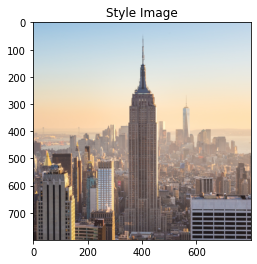

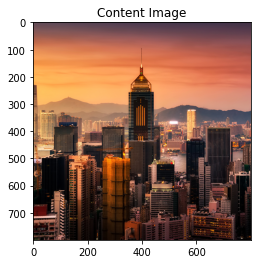

Execution time: 0.8032779693603516 seconds
Loading content image...
Execution time: 0.8358983993530273 seconds
Loading style image...
Execution time: 1.0542140007019043 seconds
Start training...
Building the style transfer model..
Execution time: 0.012479543685913086 seconds
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 1099.634888 Content Loss: 14.096299
Execution time: 4.81759786605835 seconds

run [100]:
Style Loss : 666.285950 Content Loss: 15.950265
Execution time: 10.03350281715393 seconds

run [150]:
Style Loss : 395.705536 Content Loss: 17.270184
Execution time: 15.527292490005493 seconds

run [200]:
Style Loss : 177.890762 Content Loss: 18.090574
Execution time: 21.01859998703003 seconds

run [250]:
Style Loss : 91.385406 Content Loss: 17.610159
Execution time: 26.511393070220947 seconds

run [300]:
Style Loss : 51.203400 Content Loss: 16.461117
Execution time: 32.01098442077637 seconds

run [350]:
Style Loss : 30.305490 Content Loss: 15.219622
Execution time: 37.507102251052856 seconds

run [400]:
Style Loss : 17.200577 Content Loss: 14.075668
Execution time: 42.9999680519104 seconds

run [450]:
Style Loss : 9.041111 Content Loss: 13.153433
Execution time: 48.4932587146759 seconds

run [500]:
Style Loss : 5.023064 Content Loss: 12.280298
Execution time: 53.983888149261

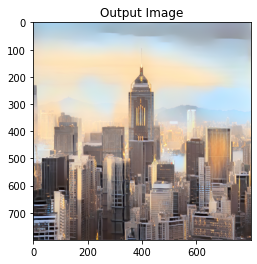

Execution time: 113.74292588233948 seconds


In [36]:
content_image_name = "drive/MyDrive/NST_proj/images/city-sunset.jpg"     #change path if needed
style_image_name   = "drive/MyDrive/NST_proj/images/city-day.jpg"

#image_proc = ImageProcessing(content_image_name, style_image_name)
#image_proc.show_images()
import time
start_time = time.time()

print('Creating NST model...')
nst_model = NST()
print('Launching...')
nst_model.run_NST(style_image_name, content_image_name)

print("Execution time: %s seconds" % (time.time() - start_time))

In [37]:
from torchvision.utils import save_image
          
          #if not self.output:
          #    raise TypeError('Nothing to save')
          #else:
!cd ./drive/MyDrive/NST_proj/images/
save_image(nst_model.output[0], 'result-4.png')
!pwd

/content
